# Tarea Final Herramientas Computacionales
---
***Nicolas Mantilla - 2210707***  
***Sofía Cárdenas - 2201381***  
***Sharith Pinzón - 2210709***

In [2]:
#Importamos las librerías necesiarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Lectura de archivos

In [3]:
data_active = pd.read_csv("../data/Global_active_power.csv",delimiter=",",header=0)
data_intensity = pd.read_csv("../data/Global_intensity.csv",delimiter=",",header=0)
data_reactive = pd.read_csv("../data/Global_reactive_power.csv",delimiter=",",header=0)
data_voltage = pd.read_csv("../data/Voltage.csv",delimiter=",",header=0)

## 2. Fusión de los cuatro archivos en uno solo

In [4]:
data = pd.merge(pd.merge(data_active, data_reactive, on=["Datetime"]),
                pd.merge(data_intensity, data_voltage, on=["Datetime"]),
                on=["Datetime"])
data["Datetime"] = pd.to_datetime(data["Datetime"], dayfirst=True)
data = data.set_index(["Datetime"])
data

,Global_active_power,Global_reactive_power,Global_intensity,Voltage
Datetime,,,,
2010-01-01 00:00:00,1.790,0.236,7.4,240.65
2010-01-01 00:01:00,1.780,0.234,7.4,240.07
2010-01-01 00:02:00,1.780,0.234,7.4,240.15
2010-01-01 00:03:00,1.746,0.186,7.2,240.26
2010-01-01 00:04:00,1.686,0.102,7.0,240.12
...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,4.0,240.43
2010-11-26 20:59:00,0.944,0.000,4.0,240.00
2010-11-26 21:00:00,0.938,0.000,3.8,239.82


## 3. *Resample* de los datos

In [92]:
# data_diario = data.resample("D").mean()
# data_mensual = data.resample("M").mean()
print(data_diario["Global_active_power"][11])

nan


## 4. Regresiones lineales

In [51]:
from scipy.optimize import curve_fit as cf

def rel1(x, a, b):
    return a*x+b

def rel3(x, a, b, c):
    return a*x[0]+b*x[1]+c

def fit(dataset, tittle):
    xdata = (dataset["Global_intensity"], dataset["Voltage"])
    ydata = dataset["Global_active_power"]
    label = ("Global active power", "Global intensity", "Voltage")
    Error = np.array([])
    for i in [1,2]:
        opt, cov = cf(rel1, xdata[i-1], ydata)
        cov = np.around(np.sqrt(np.diag(cov)), 3)
        x = np.linspace(xdata[i-1].min(), xdata[i-1].max(), 100)
        Error = np.append(Error, np.sqrt(np.mean((ydata-rel1(xdata[i-1], *opt))**2)))
        plt.figure(figsize=(8,6))
        plt.plot(x, rel1(x, *opt), 'r-', label=r'fit: {}$\pm${}'.format(np.around(tuple(opt), 3),tuple(cov)))
        plt.scatter(xdata[i-1], ydata, label="Original data")
        plt.xlabel(label[i])
        plt.ylabel(label[0])
        plt.title(tittle)
        plt.legend()
        plt.show()
        print("Los coeficientes son : {}".format(opt))
        print("El sigma de los coeficientes son : {}".format(cov))
        print("Error on fit is =", Error[i-1])
    opt, cov = cf(rel3, [xdata[0], xdata[1]], ydata)
    cov = np.around(np.sqrt(np.diag(cov)), 3)
    x = (np.linspace(xdata[0].min(), xdata[0].max(), 100), np.linspace(xdata[1].min(), xdata[1].max(), 100))
    Error = np.append(Error, np.sqrt(np.mean((ydata-rel3([xdata[0], xdata[1]], *opt))**2)))
    plt.figure(figsize=(8,6))
    plt.plot(x[0], rel3(x, *opt), 'r-', label=r'fit: {}$\pm${}'.format(np.around(tuple(opt), 3),tuple(cov)))
    plt.scatter(xdata[0], ydata, label="Original data")
    plt.ylabel(label[0])
    plt.xlabel(label[1]+" and "+ label[2])
    plt.title(tittle)
    plt.legend()
    plt.show()
    print("Los coeficientes son : {}".format(opt))
    print("El sigma de los coeficientes son : {}".format(cov))
    print("Error on fit is =", Error[2])
    return Error

# def fit(func,xdata,ydata,labelx,labely):
#     popt, pcov = curve_fit(func, xdata, ydata)
#     pcov = np.sqrt(np.diag(pcov))
#     plt.figure(figsize=(8,6))
#     plt.plot(xdata, func(xdata, *popt), 'r-',label=r'fit: {}$\pm${}'.format(tuple(popt),tuple(pcov)))
#     plt.scatter(xdata,ydata,label="Original data")
#     plt.xlabel(labelx)
#     plt.ylabel(labely)
#     plt.legend()
#     plt.show()
#     print("Los coeficientes son : {}".format(popt))
#     print("El sigma de los coeficientes son : {}".format(pcov))
#     return

# opt1, cov1 = cf(rel1, data["Global_intensity"], data["Global_active_power"])
# opt2, cov2 = cf(rel1, data["Voltage"], data["Global_active_power"])
# opt3, cov3 = cf(rel3, [data["Global_intensity"], data["Voltage"]], data["Global_active_power"])

In [76]:
opt1, cov1 = cf(rel1, data_diario["Global_intensity"], data_diario["Global_active_power"])

ValueError: array must not contain infs or NaNs

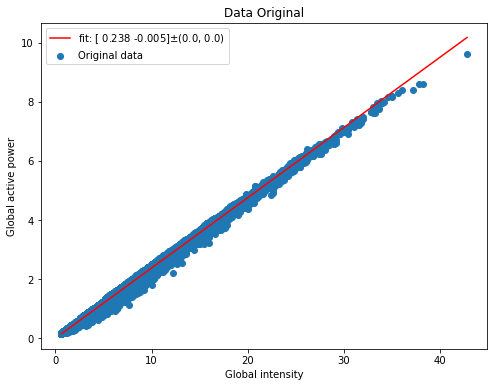

Los coeficientes son : [ 0.23803257 -0.00501581]
El sigma de los coeficientes son : [0. 0.]
Error on fit is = 0.04945239004578629


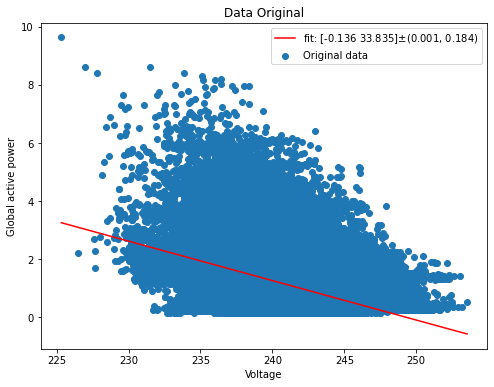

Los coeficientes son : [-0.13570432 33.83543485]
El sigma de los coeficientes son : [0.001 0.184]
Error on fit is = 0.8484264954280009


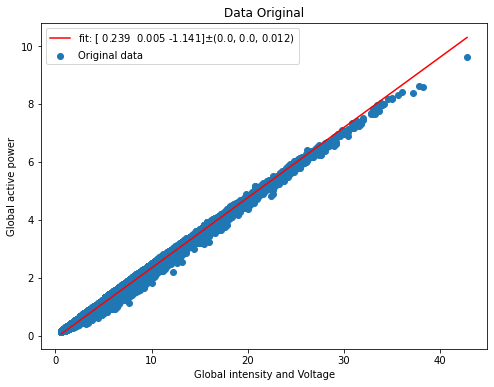

Los coeficientes son : [ 0.23948799  0.00467722 -1.1411552 ]
El sigma de los coeficientes son : [0.    0.    0.012]
Error on fit is = 0.047960962069465554


ValueError: array must not contain infs or NaNs

In [52]:
Error_original = fit(data.iloc[np.arange(0, data.shape[0], 3)], "Data Original")
Error_diario = fit(data_diario, "Data Diario")
Error_mensual = fit(data_mensual, "Data Mensual")

In [75]:
# type(data_diario.loc[:, "Global_active_power"]) != np.float64
# x
# type(data_diario["Global_active_power"][0])
# data_diario[data_diario.loc[:, "Global_active_power"].type != str]
data_mensual

,Global_active_power,Global_reactive_power,Global_intensity,Voltage
Datetime,,,,
2010-01-31,1.300640,0.125182,5.430332,242.338522
2010-02-28,1.157539,0.109467,4.836624,242.002101
2010-03-31,1.170015,0.136368,4.920399,241.475284
2010-04-30,1.036334,0.129557,4.363496,241.442527
2010-05-31,1.075957,0.127221,4.551504,241.296151
2010-06-30,0.975306,0.145525,4.170282,240.888985
2010-07-31,0.778947,0.138093,3.337202,240.965167
2010-08-31,0.929452,0.130815,3.954423,241.422944
2010-09-30,0.997541,0.127700,4.223837,241.267517
